In [ ]:
%cd drive/MyDrive
%cd 'Colab Notebooks'
%cd project

/content/drive/MyDrive
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/project


In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, average_precision_score,auc, confusion_matrix
from sklearn.metrics import matthews_corrcoef

def filter_report(report, n_classes = 29):
  res = {}
  for i in range(n_classes):
    if report[str(i)]['support'] > 0:
      res[str(i)] = report[str(i)]
  return res

def filtered_macro(filtered_report, n_classes = 29):
  prec = []
  rec = []
  f1 = []
  for label in filtered_report:
    prec.append(filtered_report[label]['precision'])
    rec.append(filtered_report[label]['recall'])
    f1.append(filtered_report[label]['f1-score'])

  return {'precision':np.mean(prec),'recall':np.mean(rec), 'f1-score':np.mean(f1)}

def mcc(confusion_matrix):
  """
  TN FP
  FN TP
  """
  TN, FP, FN, TP = np.ravel(confusion_matrix)
  TN, FP, FN, TP = int(TN), int(FP), int(FN), int(TP)
  denom = (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)
  if denom==0:
    denom=1
  numer = TP*TN - FP*FN
  return numer/np.sqrt(float(denom))


def weighted_avg_mcc(confusion_matrices, report, n_classes=29, pos_set="reliable"):
  mccs = []
  supps = []
  if pos_set == "reliable":
    # labels which do not appear in the training set
    exclude = set([3, 13, 16, 25, 26, 27])
  for i in range(n_classes):
    if i in exclude:
      continue
    supp = report[str(i)]['support']
    if supp == 0:
      continue
    supps.append(supp)
    mccs.append(mcc(confusion_matrices[i]))
  
  res = 0
  for s, m in zip(supps, mccs):
    res += s*m

  return res/sum(supps)
  

def macro_avg_mcc(confusion_matrices, report, n_classes=29, pos_set="reliable"):
  if pos_set == "reliable":
    # labels which do not appear in the training set
    exclude = set([3, 13, 16, 25, 26, 27])
    
  mccs = []
  for i in range(n_classes):
    if i in exclude:
      continue
    mccs.append(mcc(confusion_matrices[i]))
  
  return np.mean(mccs)

In [ ]:
# used to calculate multilabel confusion matrix
!pip install mlcm
from mlcm import mlcm

macro avg. MCC: 0.28064266013962014
weighted avg. MCC: 0.6044548069978879
min training loss: 0.0014695691505162897
min validation loss: 0.0029472237338069233
num epochs: 100


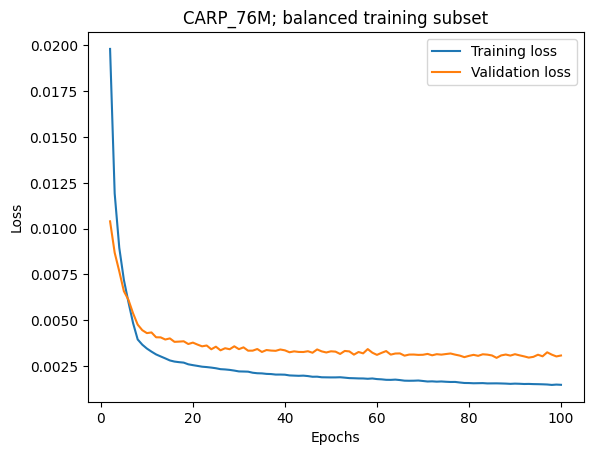

In [ ]:
# CARP crossval
dropout = 30
w = 0.1

carp_dim = "76M"
model_name = f"CARP_CNN"

window_len = 3
loss_name = "BCE"

subset = "BALANCED"
model_dir = f"{model_name}_{window_len}W_{loss_name}"
subset_dir = f"{subset}/FINAL_TESTS/carp_{carp_dim}/weight_decay_{w}"
final_dir = f"MODEL_EXPERIMENTS/{subset_dir}/{model_dir}"
threshold_path = f"{final_dir}/validation"

with open(f"{threshold_path}/global_classification_report", "r") as f:
  report = json.load(f)

with open(f"{threshold_path}/confusion", "rb") as f:
  confusion = np.load(f)

with open(f"{threshold_path}/y_probs", "rb") as f:
  y_probs = np.load(f)

with open(f"{threshold_path}/y_true", "rb") as f:
  y_true = np.load(f)

train_loss_path = f"{final_dir}/running_train_losses"
val_loss_path = f"{final_dir}/running_val_losses"

with open(train_loss_path, "rb") as f:
  running_train_losses = pickle.load(f)
with open(val_loss_path, "rb") as f:
  running_val_losses = pickle.load(f)
num_epochs = len(running_train_losses)
r = range(1,num_epochs+1)

print(f"macro avg. MCC: {macro_avg_mcc(confusion, report)}")
print(f"weighted avg. MCC: {weighted_avg_mcc(confusion, report)}")
print(f"min training loss: {min(running_train_losses)}")
print(f"min validation loss: {min(running_val_losses)}")
print(f"num epochs: {len(running_train_losses)}")

plt.plot(r[1:], running_train_losses[1:], label="Training loss")
plt.plot(r[1:], running_val_losses[1:], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"CARP_{carp_dim}; balanced training subset")
plt.legend(loc="upper right")
plt.show()

In [ ]:
print("auc MCC")
for label in range(29):
  prec, rec, thresholds = precision_recall_curve(y_true[:, label], y_probs[:, label])
  print(f"{label} {auc(rec, prec)} {mcc(confusion[label])}")

auc MCC


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


0 0.5 0.0
1 0.46720648707883977 0.47841618249044515
2 0.006359491841206171 0.0
3 0.0041248886050028535 0.0
4 0.8602893757095479 0.7817007811613428


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


5 0.5 0.0
6 0.033845304553847974 0.0
7 0.5465115153730522 0.5295574152228341
8 0.949945136614137 0.8913253677404283
9 0.18525324353465983 0.26757917874198994
10 0.00526986701138297 0.0
11 0.006380695750041304 0.0
12 0.8498088597894377 0.7968345731118555
13 0.5 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


14 0.3711737220935069 0.348381750929522
15 0.10728229652130952 0.0
16 1.0 0.0
17 0.0261076482716559 0.0
18 0.15812330031202088 0.0
19 0.0730888274006538 0.0
20 0.00012286401400994653 0.0
21 0.002255385123730659 0.0
22 0.7524162588182991 0.6788512731736234


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


23 0.5 0.0
24 0.5285770977200459 0.5125847640557588
25 0.04587346084991029 0.0
26 0.5 0.0
27 0.5 0.0
28 0.569780637298151 0.5418086586382073


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


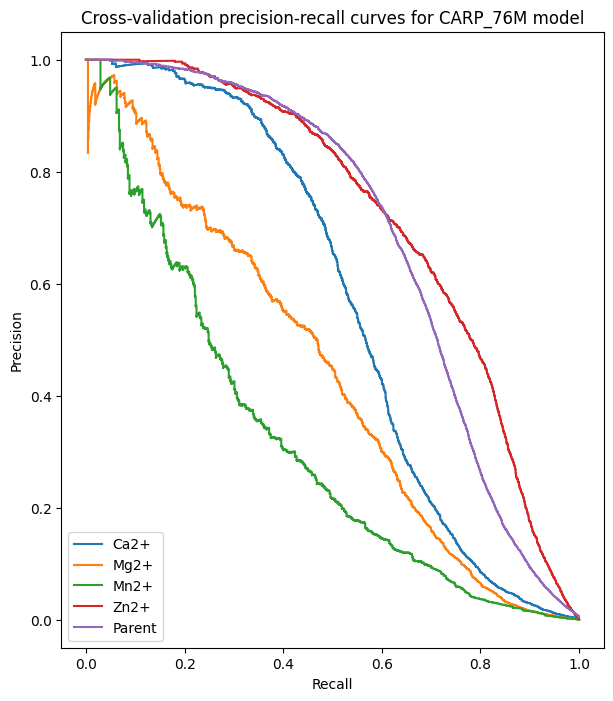

In [ ]:
# CROSS-VAL prec. rec. curves

labels = {1:"Ca2+",
          14:"Mg2+",
          15:"Mn2+",
          24:"Zn2+",
          28:"Parent"}
_, ax = plt.subplots(figsize=(7, 8))
ax.set_title("Cross-validation precision-recall curves for CARP_76M model")
for label, name in labels.items():
  prec, rec, thresholds = precision_recall_curve(y_true[:, label], y_probs[:, label])
  display = PrecisionRecallDisplay(
    recall=rec,
    precision=prec
  )
  display.plot(ax=ax, name=name)

macro avg. MCC: 0.07634325071953006
weighted avg. MCC: 0.45439085657330125
min training loss: 0.0016223469204506126
min validation loss: 0.003983805181331447
num epochs: 90


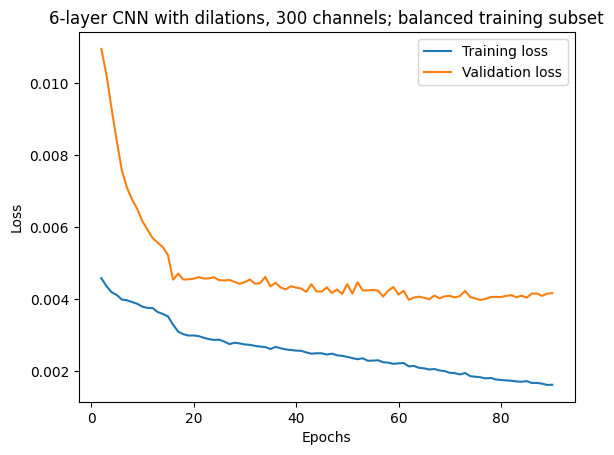

In [ ]:
# CROSS-VAL
depth = 6
width = 300

dropout = 30
w = 0.1

#model_name = f"Test_CNN_{depth}_{width}_Dropout{dropout}" if dropout else f"Test_CNN_{depth}_{width}"
model_name = f"Dil_CNN_{depth}_{width}_Dropout{dropout}"
window_len = 3
#loss_name = "FOCAL_a0.7_g1"
loss_name = "BCE"

subset = "BALANCED"
model_dir = f"{model_name}_{window_len}W_{loss_name}"
subset_dir = f"{subset}/FINAL_TESTS/weight_decay_{w}"
final_dir = f"MODEL_EXPERIMENTS/{subset_dir}/{model_dir}"
threshold_path = f"{final_dir}/validation"

with open(f"{threshold_path}/global_classification_report", "r") as f:
  report = json.load(f)

with open(f"{threshold_path}/confusion", "rb") as f:
  confusion = np.load(f)

with open(f"{threshold_path}/y_probs", "rb") as f:
  y_probs = np.load(f)

with open(f"{threshold_path}/y_true", "rb") as f:
  y_true = np.load(f)

train_loss_path = f"{final_dir}/running_train_losses"
val_loss_path = f"{final_dir}/running_val_losses"

with open(train_loss_path, "rb") as f:
  running_train_losses = pickle.load(f)
with open(val_loss_path, "rb") as f:
  running_val_losses = pickle.load(f)
num_epochs = len(running_train_losses)
r = range(1,num_epochs+1)

print(f"macro avg. MCC: {macro_avg_mcc(confusion, report)}")
print(f"weighted avg. MCC: {weighted_avg_mcc(confusion, report)}")
print(f"min training loss: {min(running_train_losses)}")
print(f"min validation loss: {min(running_val_losses)}")
print(f"num epochs: {len(running_train_losses)}")

plt.plot(r[1:], running_train_losses[1:], label="Training loss")
plt.plot(r[1:], running_val_losses[1:], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"{depth}-layer CNN with dilations, {width} channels; balanced training subset")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# BASELINE RESULTS

depth = 5
width = 300
rows = []
for dropout in [0, 10, 20, 30]:
  row = []
  for w in [0, 0.001, 0.01, 0.1]:
    model_name = f"Test_CNN_{depth}_{width}_Dropout{dropout}" if dropout else f"Test_CNN_{depth}_{width}"
    window_len = 3
    loss_name = "BCE"

    subset = "BALANCED"
    model_dir = f"{model_name}_{window_len}W_{loss_name}"
    subset_dir = f"{subset}/FINAL_TESTS/weight_decay_{w}"
    final_dir = f"MODEL_EXPERIMENTS/{subset_dir}/{model_dir}"
    threshold_path = f"{final_dir}/validation"

    with open(f"{threshold_path}/global_classification_report", "r") as f:
      report = json.load(f)

    with open(f"{threshold_path}/confusion", "rb") as f:
      confusion = np.load(f)

    row.append(str(float(weighted_avg_mcc(confusion, report))))

  rows.append(" ".join(row))

print('\n'.join(rows))

0.06378727215461494 0.055559877051012486 0.09584256488712001 0.09579227992681062
0.04538536764760153 0.13095307841807202 0.1702437891371796 0.13712290901997004
0.21484639752915285 0.2675577480949914 0.29659840568618223 0.21643397648765092
0.27226228485000353 0.28656323167968567 0.33167980812797493 0.3331780611910137


In [ ]:
# FOCAL LOSS RESULTS

depth = 6
width = 300
rows = []
dropout = 30
w=0.1
for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
  row = []
  for gamma in [1, 2, 3]:
    model_name = f"Test_CNN_{depth}_{width}_Dropout{dropout}" if dropout else f"Test_CNN_{depth}_{width}"
    window_len = 3
    loss_name = f"FOCAL_a{alpha}_g{gamma}"

    subset = "BALANCED"
    model_dir = f"{model_name}_{window_len}W_{loss_name}"
    subset_dir = f"{subset}/FINAL_TESTS/weight_decay_{w}"
    final_dir = f"MODEL_EXPERIMENTS/{subset_dir}/{model_dir}"
    threshold_path = f"{final_dir}/validation"

    with open(f"{threshold_path}/global_classification_report", "r") as f:
      report = json.load(f)

    with open(f"{threshold_path}/confusion", "rb") as f:
      confusion = np.load(f)

    row.append(str(float(weighted_avg_mcc(confusion, report))))

  rows.append(" ".join(row))

print('\n'.join(rows))

0.0 0.18828594308494695 0.0
0.26126393747425763 0.167511060039745 0.13143017415316263
0.27758647542271087 0.33045897054921813 0.21876711437498944
0.3748964149972926 0.24892587590370877 0.26587772145023447
0.3038415755163192 0.25293128747670107 0.2614388889220234


macro avg. MCC: 0.8623466082807809
weighted avg. MCC: 0.977888102939033
min training loss: 6.10924048256277e-05
num epochs: 300


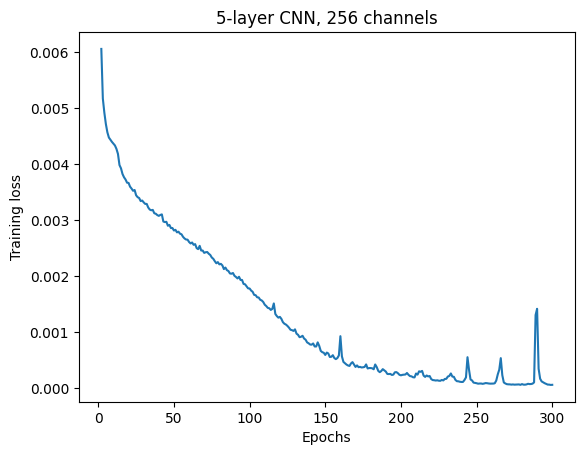

In [ ]:
# OVERFIT TEST
depth = 5
width = 256
model_name = f"Test_CNN_{depth}_{width}"
window_len = 3
loss_name = "BCE"
model_dir = f"{model_name}_{window_len}W_{loss_name}"
subset_dir = "BALANCED"
test_dir = "FINAL_TESTS/OVERFIT_TEST"
final_dir = f"MODEL_EXPERIMENTS/{subset_dir}/{test_dir}/{model_dir}"
threshold_path = f"{final_dir}/train"

with open(f"{threshold_path}/global_classification_report", "r") as f:
  report = json.load(f)

with open(f"{threshold_path}/confusion", "rb") as f:
  confusion = np.load(f)

with open(f"{threshold_path}/y_probs", "rb") as f:
  y_probs = np.load(f)

with open(f"{threshold_path}/y_true", "rb") as f:
  y_true = np.load(f)

train_loss_path = f"{final_dir}/running_train_losses"
val_loss_path = f"{final_dir}/running_val_losses"

with open(train_loss_path, "rb") as f:
  running_train_losses = pickle.load(f)
num_epochs = len(running_train_losses)
r = range(1,num_epochs+1)

print(f"macro avg. MCC: {macro_avg_mcc(confusion, report)}")
print(f"weighted avg. MCC: {weighted_avg_mcc(confusion, report)}")
print(f"min training loss: {min(running_train_losses)}")
print(f"num epochs: {len(running_train_losses)}")

plt.plot(r[1:], running_train_losses[1:])
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.title(f"{depth}-layer CNN, {width} channels")
plt.show()

macro avg. MCC: 0.25334956283765253
weighted avg. MCC: 0.5124310812714814
min training loss: 0.0009861591423748796
num epochs: 150
auc: 0.569780637298151


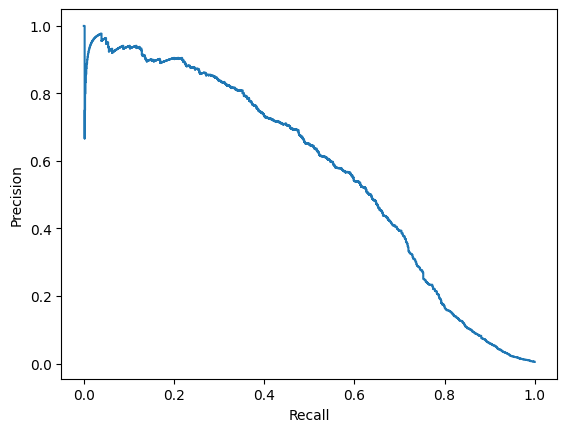

In [ ]:
# FINAL MODEL

depth=6
dropout=30
width=400

model_name = "CARP_CNN"
#model_name = f"Test_CNN_{depth}_{width}_Dropout{dropout}" if dropout else f"Test_CNN_{depth}_{width}"
#model_name = f"Dil_CNN_{depth}_{width}_Dropout{dropout}"

window_len = 3
loss_name = "BCE"
#loss_name = "FOCAL_a0.7_g1"

subset = "BALANCED/carp_76M"
#subset="BALANCED"
#subset="REDUCED_40"
epoch = 100
w = 0.1

model_dir = f"{model_name}_{window_len}W_{loss_name}"
subset_dir = f"{subset}/weight_decay_{w}"
final_dir = f"FINAL_MODEL/{subset_dir}/{model_dir}"
threshold_path = f"{final_dir}/{epoch}/test"

with open(f"{threshold_path}/global_classification_report", "r") as f:
  report = json.load(f)

with open(f"{threshold_path}/confusion", "rb") as f:
  confusion = np.load(f)

with open(f"{threshold_path}/y_probs", "rb") as f:
  y_probs = np.load(f)

with open(f"{threshold_path}/y_true", "rb") as f:
  y_true = np.load(f)

train_loss_path = f"{final_dir}/running_train_losses"
val_loss_path = f"{final_dir}/running_val_losses"

with open(train_loss_path, "rb") as f:
  running_train_losses = pickle.load(f)
num_epochs = len(running_train_losses)
r = range(1,num_epochs+1)

print(f"macro avg. MCC: {macro_avg_mcc(confusion, report)}")
print(f"weighted avg. MCC: {weighted_avg_mcc(confusion, report)}")
print(f"min training loss: {min(running_train_losses)}")
print(f"num epochs: {len(running_train_losses)}")

label = 28
prec, rec, thresholds = precision_recall_curve(y_true[:, label], y_probs[:, label])

display = PrecisionRecallDisplay(
    recall=rec,
    precision=prec
)
display.plot()
print(f"auc: {auc(rec, prec)}")

THRESHOLD TUNING

In [ ]:
# Ca2+ - 1
# Mg2+ - 14
# Mn2+ - 15
# Fe3+ - 11
# Zn2+ - 24
# Parent- 28

for label in [1,14,15,11,24,28]:
  targets = y_true[:, label]
  print(label)
  best_thresh = None
  best_MCC = -2
  for thresh in np.arange(0,1,0.001):
    preds = y_probs[:, label] > thresh
    curr_MCC = matthews_corrcoef(targets, preds)
    if curr_MCC > best_MCC:
      best_MCC = curr_MCC
      best_thresh = thresh
  
  print(f"thresh. {best_thresh}, MCC. {best_MCC}")

1
thresh. 0.28500000000000003, MCC. 0.5047149940727829
14
thresh. 0.189, MCC. 0.48240723550543374
15
thresh. 0.171, MCC. 0.2396269891283021
11
thresh. 0.0, MCC. 0.0
24
thresh. 0.193, MCC. 0.5325514877452694
28
thresh. 0.196, MCC. 0.5759101906797657


FINAL MODEL CONFUSION MATRIX

[]

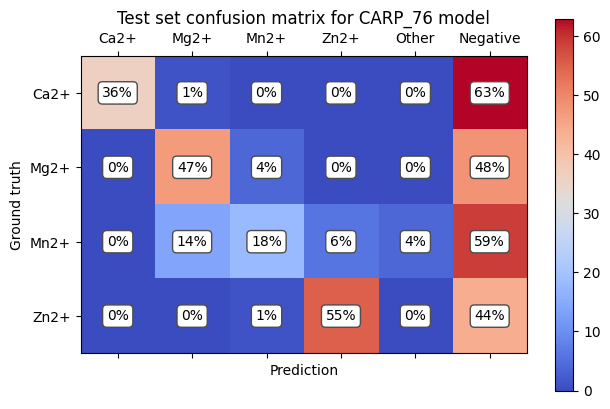

In [ ]:
# Ca2+ - 1
# Mg2+ - 14
# Mn2+ - 15
# Zn2+ - 24
target_labels = [1, 14, 15, 24]

all_labels = list(range(29))
ordered_labels = target_labels + [x for x in all_labels if x not in target_labels]
# optimised thresholds
thresh_list = [0.285, 0.189, 0.171, 0.193] + [0.5]*(29-4)
targets, preds = y_true[:, ordered_labels], y_probs[:, ordered_labels] > thresh_list
cm, norm_cm = mlcm.cm(targets, preds)

agg_columns = norm_cm[:, 4:29]
summed = np.sum(agg_columns, axis=1)
new_norm_cm = np.concatenate([norm_cm[:,:4], summed.reshape((30,1)), norm_cm[:,29][:,np.newaxis]], axis=1)

plt.matshow(new_norm_cm[:4], cmap="coolwarm")
for (i, j), z in np.ndenumerate(new_norm_cm[:4]):
    plt.gca().text(j, i, f"{int(z)}%", ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
plt.xticks([0,1,2,3,4,5], labels=["Ca2+","Mg2+","Mn2+","Zn2+","Other","Negative"])
plt.yticks([0,1,2,3], labels=["Ca2+","Mg2+","Mn2+","Zn2+"])
plt.xlabel("Prediction")
plt.ylabel("Ground truth")
plt.title("Test set confusion matrix for CARP_76 model")
plt.colorbar()

plt.plot()

FINAL MODEL PRECISION RECALL CURVES

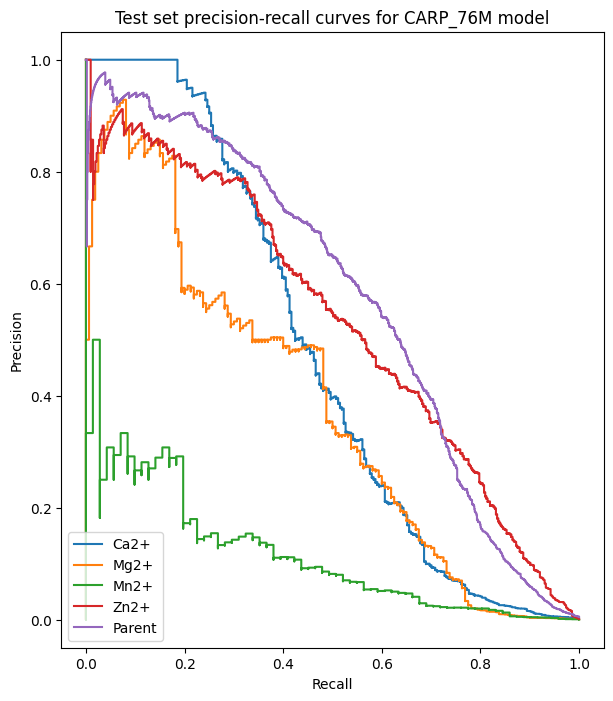

In [ ]:
labels = {1:"Ca2+",
          14:"Mg2+",
          15:"Mn2+",
          24:"Zn2+",
          28:"Parent"}
_, ax = plt.subplots(figsize=(7, 8))
ax.set_title("Test set precision-recall curves for CARP_76M model")
for label, name in labels.items():
  prec, rec, thresholds = precision_recall_curve(y_true[:, label], y_probs[:, label])
  display = PrecisionRecallDisplay(
    recall=rec,
    precision=prec
  )
  display.plot(ax=ax, name=name)

FINDING BEST BASELINE MODEL

In [ ]:
width = 128
model_names = [f"Test_CNN_5_{width}", f"Test_CNN_5_{width}_Dropout10", f"Test_CNN_5_{width}_Dropout20", f"Test_CNN_5_{width}_Dropout30"]
window_len = 3
loss_name = "BCE"
min_loss = 99
for model_name in model_names:
  for w in [0, 0.1, 0.01, 0.001]:
    model_dir = f"{model_name}_{window_len}W_{loss_name}"
    subset_dir = f"BALANCED/FINAL_TESTS/weight_decay_{w}"
    final_dir = f"MODEL_EXPERIMENTS/{subset_dir}/{model_dir}"
    train_loss_path = f"{final_dir}/running_train_losses"
    val_loss_path = f"{final_dir}/running_val_losses"

    with open(train_loss_path, "rb") as f:
      running_train_losses = pickle.load(f)
    with open(val_loss_path, "rb") as f:
      running_val_losses = pickle.load(f)
    
    print(f"{model_name} with weight decay {w}")
    print(f"min training loss: {min(running_train_losses)}")
    print(f"min validation loss: {min(running_val_losses)}")
    print(f"num epochs: {len(running_train_losses)}")
    if min(running_val_losses) < min_loss:
      min_loss = min(running_val_losses)
      best = f"{model_name} with weight decay {w}"

print(f"best is {best}")

In [ ]:
width = 256
d = 30
model_names = [f"Test_CNN_5_{width}_Dropout{d}", f"Test_CNN_6_{width}_Dropout{d}", f"Test_CNN_7_{width}_Dropout{d}",]
window_len = 3
loss_name = "BCE"
min_loss = 99
w = 0.1
for model_name in model_names:
  model_dir = f"{model_name}_{window_len}W_{loss_name}"
  subset_dir = f"BALANCED/FINAL_TESTS/weight_decay_{w}"
  final_dir = f"MODEL_EXPERIMENTS/{subset_dir}/{model_dir}"
  train_loss_path = f"{final_dir}/running_train_losses"
  val_loss_path = f"{final_dir}/running_val_losses"

  with open(train_loss_path, "rb") as f:
    running_train_losses = pickle.load(f)
  with open(val_loss_path, "rb") as f:
    running_val_losses = pickle.load(f)
  
  print(f"{model_name} with weight decay {w}")
  print(f"min training loss: {min(running_train_losses)}")
  print(f"min validation loss: {min(running_val_losses)}")
  print(f"num epochs: {len(running_train_losses)}")
  if min(running_val_losses) < min_loss:
    min_loss = min(running_val_losses)
    best = f"{model_name} with weight decay {w}"

print(f"best is {best}")

In [ ]:
width = 300
d = 30
model_name = f"Test_CNN_6_{width}_Dropout{d}"
window_len = 3
loss_name = "BCE"
min_loss = 99
subset = "REDUCED_40"

for w in [0.1, 0.01, 0.001]:
  model_dir = f"{model_name}_{window_len}W_{loss_name}"
  subset_dir = f"{subset}/FINAL_TESTS/weight_decay_{w}"
  final_dir = f"MODEL_EXPERIMENTS/{subset_dir}/{model_dir}"
  train_loss_path = f"{final_dir}/running_train_losses"
  val_loss_path = f"{final_dir}/running_val_losses"

  with open(train_loss_path, "rb") as f:
    running_train_losses = pickle.load(f)
  with open(val_loss_path, "rb") as f:
    running_val_losses = pickle.load(f)
  
  print(f"{model_name} with weight decay {w}")
  print(f"min training loss: {min(running_train_losses)}")
  print(f"min validation loss: {min(running_val_losses)}")
  print(f"num epochs: {len(running_train_losses)}")
  if min(running_val_losses) < min_loss:
    min_loss = min(running_val_losses)
    best = f"{model_name} with weight decay {w}"

print(f"best is {best}")

Test_CNN_6_300_Dropout30 with weight decay 0.1
min training loss: 0.00028325270499527755
min validation loss: 0.000719479188684854
num epochs: 38
Test_CNN_6_300_Dropout30 with weight decay 0.01
min training loss: 0.0003287688331823692
min validation loss: 0.0007270750667407508
num epochs: 36
Test_CNN_6_300_Dropout30 with weight decay 0.001
min training loss: 0.0003739461890325956
min validation loss: 0.0007347989173286225
num epochs: 30
best is Test_CNN_6_300_Dropout30 with weight decay 0.1
